In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Define cluster loss. Student's-t distribution with a regularization term (currently commented out)

In [84]:
def cluster_loss(z, centers):
    z = tf.reshape(z, [tf.shape(z)[0], 1, tf.shape(z)[1]])

    centers_r = tf.reshape(centers, [1, tf.shape(centers)[0], tf.shape(centers)[1]])
    partial = tf.math.pow(tf.squeeze(tf.norm(z - centers_r, ord='euclidean', axis=2)), 2)
    nominator = 1 / (1 + partial)
    denominator = tf.math.reduce_sum(1 / (1 + partial), axis=1)
    denominator = tf.reshape(denominator, [tf.shape(denominator)[0], 1])
    q = nominator / denominator
    q_norm = 1 - q
    q_norm = tf.math.log(q_norm + 0.00001)  # e for 0 logs
    return tf.reduce_sum(q_norm, axis=1) # + tf.reduce_sum(tf.norm(centers, ord='euclidean', axis=1))

## First example

Dummy centers and z's

In [9]:
c = [[0], [1]]
c = np.array(c, dtype=np.float32)

In [10]:
c.shape

(2, 1)

In [11]:
z = [[0.2], [0.4], [0.6], [0.7]]
z = np.array(z, dtype=np.float32)

In [12]:
z.shape

(4, 1)

Calculate loss and print values

In [12]:
loss = cluster_loss(z, c)

In [13]:
loss.shape

TensorShape([4])

Text(0.5, 1.0, 'centers=[0.], [1.]')

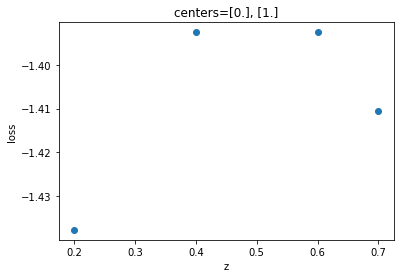

In [21]:
plt.scatter(z, loss)
plt.xlabel('z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

## Second example

In [5]:
c = [[0, 0, 0, 0], [1, 1, 1, 1]]
c = np.array(c, dtype=np.float32)
z = [[0.2, 0.2, 0.2, 0.2], [0.1, 0.4, 0.3, 0.6], [0.8, 0.8, 0.4, 0.5], [0.5, 0.9, 0.4, 0.5], [0.5, 0.5, 0.5, 0.5]]
z = np.array(z, dtype=np.float32)

Calculate loss and print values with respect to norm z

In [57]:
loss = cluster_loss(z, c)

Text(0.5, 1.0, 'centers=[0. 0. 0. 0.], [1. 1. 1. 1.]')

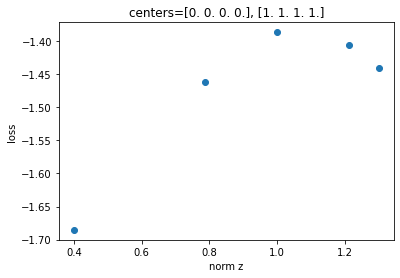

In [58]:
plt.scatter(tf.norm(z, ord='euclidean', axis=1), loss)
plt.xlabel('norm z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

## Third example

In [69]:
c = [[0, 0], [1, 1]]
c = np.array(c, dtype=np.float32)
z = [[0.1, 0.2], [0.1, 0.4], [0.8, 0.8], [0.5, 0.9], [0.5, 0.5]]
z = np.array(z, dtype=np.float32)

In [70]:
loss = cluster_loss(z, c)
loss

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.5606002, -1.4801667, -1.5226996, -1.4460692, -1.3862543],
      dtype=float32)>

Text(0.5, 1.0, 'centers=[0. 0.], [1. 1.]')

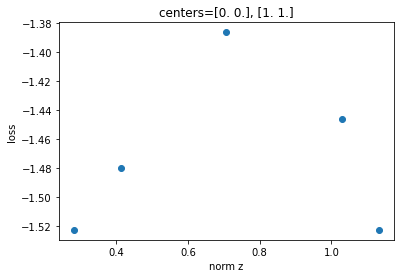

In [61]:
plt.scatter(tf.norm(z, ord='euclidean', axis=1), loss)
plt.xlabel('norm z')
plt.ylabel('loss')
plt.title('centers={}, {}'.format(c[0], c[1]))

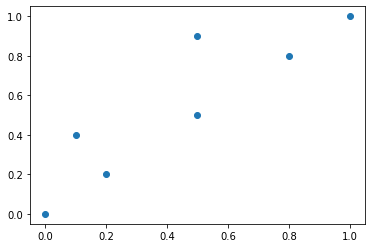

In [65]:
concat = np.concatenate((z, c))
plt.scatter(concat[:, 0], concat[:, 1])

# Clustering loss - Cluster centers movement

Test whether clustering loss moves centers towards the closest Zs

In [85]:
z = tf.constant([[0, 0], [1, 1]], dtype=tf.float32)
c = tf.Variable([[0.3, 0.4], [0.7, 0.9]]) # 2 centers with dimension 2

Plot initial layout

Text(0.5, 1.0, 'Embeddings (.) and centers (x)')

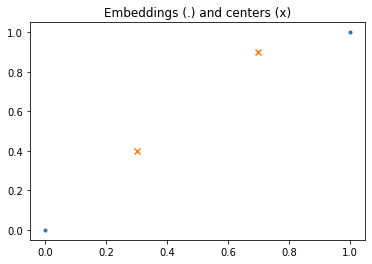

In [86]:
plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.scatter(c[:, 0], c[:, 1], marker='x')
plt.title('Embeddings (.) and centers (x)')

Apply training

In [87]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
for i in range(50):
    with tf.GradientTape() as tape:
        loss = cluster_loss(z, c)
    gradients = tape.gradient(loss, [c])
    optimizer.apply_gradients(zip(gradients, [c]))
print(c)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.24926881, 0.34917438],
       [0.7506762 , 0.9504692 ]], dtype=float32)>


Re-plot layout to observe changes

Text(0.5, 1.0, 'Embeddings (.) and centers (x)')

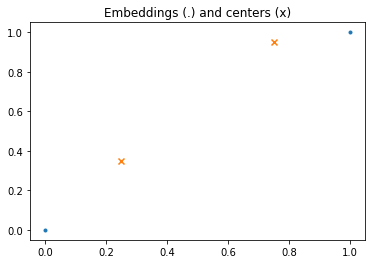

In [88]:
plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.scatter(c[:, 0], c[:, 1], marker='x')
plt.title('Embeddings (.) and centers (x)')

## Observations:
1) Without regularization, the behavior is the desirable. Each center moves towards its closest embedding

2) With regularization however, the center at [0.7, 0.9] moves towards the other center. This makes sense as the regularization closes the gap between centers

3) Using a factor of 0.3 for the regularization part still reproduces the issue. You have to fall down to 0.1 to observe the expected behavior, but then... what is the purpose of regularization.

# LOGSUMEXP as smoothmin loss

In [98]:
def cluster_loss(z, centers, p=2):
    z = tf.reshape(z, [tf.shape(z)[0], 1, tf.shape(z)[1]])

    centers_r = tf.reshape(centers, [1, tf.shape(centers)[0], tf.shape(centers)[1]])
    f = - (1/p) * tf.math.log(tf.reduce_sum(tf.math.exp(-p * (z - centers_r)), axis=2) + 0.00001)
    return tf.reduce_sum(f, axis=1) # + tf.reduce_sum(tf.norm(centers, ord='euclidean', axis=1))

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.39997742, 0.49999917],
       [0.7981583 , 1.0000129 ]], dtype=float32)>


Text(0.5, 1.0, 'Embeddings (.) and centers (x)')

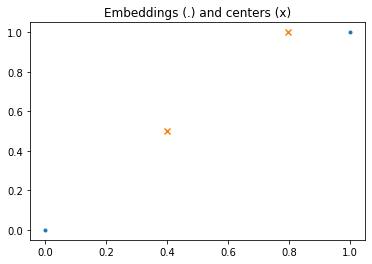

In [101]:
z = tf.constant([[0, 0], [1, 1]], dtype=tf.float32)
c = tf.Variable([[0.3, 0.4], [0.7, 0.9]]) # 2 centers with dimension 2

optimizer = tf.keras.optimizers.Adam(lr=0.001)
for i in range(100):
    with tf.GradientTape() as tape:
        loss = cluster_loss(z, c, 50)
    gradients = tape.gradient(loss, [c])
    optimizer.apply_gradients(zip(gradients, [c]))
print(c)

plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.scatter(c[:, 0], c[:, 1], marker='x')
plt.title('Embeddings (.) and centers (x)')

LOGSUMEXP doesn't work as expected. Both centers seem to move to the same direction